In [ ]:
!pip install stellargraph

In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import stellargraph as sg
import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [ ]:
graph = nx.read_gml('graph_node2vec2.gml')
node_subjects = nx.get_node_attributes(graph,'genre')

In [ ]:
counter =0
list_of_ids =[]
for key, value in node_subjects.items():
    if len(value) != 0:
        list_of_ids.append(counter)
    counter +=1
print(len(list_of_ids))

17777


In [ ]:
index_list = [*range(0, len(node_subjects), 1)] 
node_subjects= pd.Series(list(node_subjects.values())[0:len(node_subjects)], index = index_list, name= "genre")
print(node_subjects)

0           jazz
1            pop
2        country
3           rock
4          blues
          ...   
53275           
53276           
53277           
53278           
53279           
Name: genre, Length: 53280, dtype: object


In [ ]:
print(counter)
matrix=[]
for i in range(counter):
    vecForEach = np.zeros(2)
    if i > len(list_of_ids):
        vecForEach[1] = 1 #represents its a song node
    else:
        vecForEach[0] = 1 #represents its a word node
    matrix.append(vecForEach)

index = [*range(0,counter,1)]
list_of_tuples = list(zip(index, matrix))
df = pd.DataFrame(list_of_tuples,  columns = ['index', 'value'])   
df

53280


,index,value
0,0,"[1.0, 0.0]"
1,1,"[1.0, 0.0]"
2,2,"[1.0, 0.0]"
3,3,"[1.0, 0.0]"
4,4,"[1.0, 0.0]"
...,...,...
53275,53275,"[0.0, 1.0]"
53276,53276,"[0.0, 1.0]"
53277,53277,"[0.0, 1.0]"
53278,53278,"[0.0, 1.0]"


In [ ]:
i=0
for u,outer_d in graph.nodes(data=True):
    #print(type(df.iloc[i]['value']))
    outer_d['val'] = df.iloc[i]['value']
    i+=1

In [ ]:
G = sg.StellarGraph.from_networkx(graph,node_features="val")
G.info()

'StellarGraph: Undirected multigraph\n Nodes: 53280, Edges: 794103\n\n Node types:\n  default: [53280]\n    Features: float32 vector, length 2\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [794103]\n        Weights: all 1 (default)\n        Features: none'

In [ ]:
G.nodes()[0:len(node_subjects)]

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '53270', '53271', '53272', '53273', '53274', '53275', '53276', '53277',
       '53278', '53279'],
      dtype='object', length=53280)

In [ ]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()[0:len(list_of_ids)]),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 177770


In [ ]:
# save generated walks, because it takes a long time
import json
with open("walks.txt", "w") as f:
  json.dump(walks, f)

In [ ]:
# Open walks from saved file
# import json
# f = open('walks.txt',)
# walks = json.load(f)

In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# model.wv["19231"].shape

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings[0:len(list_of_ids)])

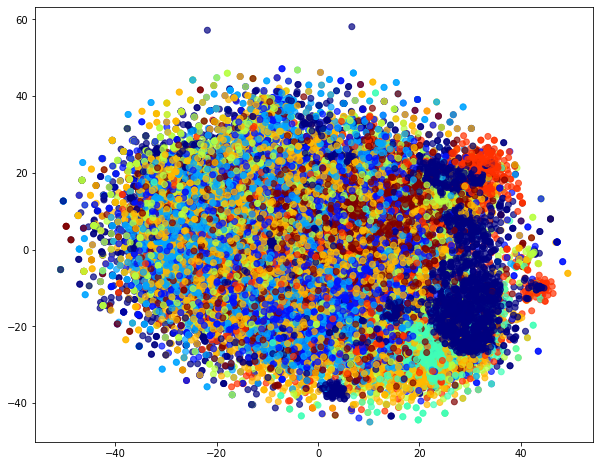

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets[0:len(list_of_ids)]))}
node_colours = [label_map[target] for target in node_targets[0:len(list_of_ids)]]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [ ]:
# X will hold the 128-dimensional input features
X = node_embeddings[0:len(list_of_ids)]
# y holds the corresponding target values
y = np.array(node_targets[0:len(list_of_ids)])

In [ ]:
node_targets

53279     
17930     
17855     
17862     
17806     
        ..
32409     
40916     
34001     
41373     
48977     
Name: genre, Length: 53278, dtype: object

In [ ]:
node_embeddings

array([[-0.08028887,  0.06463741,  0.14499411, ...,  0.18887125,
         0.08556242, -0.22926944],
       [ 0.00375228, -0.07394035,  0.05633977, ..., -0.0118255 ,
        -0.1089333 ,  0.13999107],
       [ 0.16784865, -0.07214049, -0.03906646, ..., -0.1339302 ,
         0.09432771,  0.10857826],
       ...,
       [ 0.02947808,  0.01283296, -0.03887498, ...,  0.03979995,
        -0.03234305, -0.01247147],
       [ 0.06394347,  0.00859884, -0.01844043, ...,  0.0829802 ,
        -0.00521385, -0.03229484],
       [ 0.0547693 ,  0.00724381, -0.00910291, ...,  0.05415199,
        -0.027115  , -0.00171331]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=None)

In [ ]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (14221, 128)
 y_train = (14221,)
 X_test = (3556, 128)
 y_test = (3556,)


In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring='accuracy',
                     solver='lbfgs', tol=0.0001, verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_test

array(['blues', 'blues', '', ..., 'pop', 'pop', 'pop'], dtype=object)

In [ ]:
y_pred

array(['rock', 'pop', '', ..., 'pop', 'pop', 'country'], dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

0.5109673790776152